<a href="https://colab.research.google.com/github/AryanRaj315/HeadPoseEstimation/blob/master/HeadPoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the dataset and installing necessary libraries
Dataset link : https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db

In [3]:
!wget http://data.vision.ee.ethz.ch/cvl/gfanelli/kinect_head_pose_db.tgz

--2019-12-03 06:21:41--  http://data.vision.ee.ethz.ch/cvl/gfanelli/kinect_head_pose_db.tgz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/gfanelli/kinect_head_pose_db.tgz [following]
--2019-12-03 06:21:41--  https://data.vision.ee.ethz.ch/cvl/gfanelli/kinect_head_pose_db.tgz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6014398431 (5.6G) [application/x-gzip]
Saving to: ‘kinect_head_pose_db.tgz’

kinect_head_pose_db 100%[===================>]   5.60G  17.4MB/s    in 5m 3s   

2019-12-03 06:26:43 (19.0 MB/s) - ‘kinect_head_pose_db.tgz’ saved [6014398431/6014398431]



Extracting the .tgz file 

In [0]:
!tar -xf '/content/kinect_head_pose_db.tgz'

In [0]:
import os
import cv2
from math import atan2, asin 
import numpy as np
import pandas as pd
import dlib
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, Dataset, sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations.pytorch import ToTensor
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import torch
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.models as models
import time

In [6]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!7z x "mmod_human_face_detector.dat.bz2"
detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

--2019-12-03 06:28:12--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   561KB/s    in 1.2s    

2019-12-03 06:28:14 (561 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 694709 bytes (679 KiB)

Extracting archive: mmod_human_face_detector.dat.bz2
--
Path = mmod_human_face_detector.dat.bz2
Type = bzip2

  0% - mmod_human_face_detector.dat                                   

# Useful functions

Function to get the path

In [0]:
def PathList(path):
  Img_Path = []
  for root, dirs, files in os.walk(path, topdown=False):
      for filename in files:
        if(filename[-3:] == 'png'):
          Img_Path.append(root+'/'+filename)
  return Img_Path        

Here ImagesPath is a list that contains all the .png files from the dataset

In [0]:
ImagesPath = PathList("hpdb/")

This function is used to convert the transformation matrix from 
all the .txt files to Yaw, Pitch and Roll 

In [0]:
def getAngles(path):
  rot_mat = []
  with open(path, "r") as f:
    l = f.read()
    l = l.split("\n")
    for i in range(0, 3): 
      rot_mat.append(l[i].split(" ")[:3])
    rot_mat = np.asarray(rot_mat)
    rot_mat = rot_mat.astype(float) 
    roll = atan2(rot_mat[2][1], rot_mat[2][2]);
    pitch = asin(rot_mat[2][0]);
    yaw = -atan2(rot_mat[1][0], rot_mat[0][0]);
  return yaw, pitch, roll 

In [0]:
# !rm -r 'hpdb/01/frame_00003_rgb.png'

This function is used to crop out unnecessary background from the .png files which will later be used for the face extraction 

In [0]:
def crop():
  j = 1
  k = 1
  rows = 24
  columns = 2
  fig=plt.figure(figsize=(20, 100))
  for i in tqdm(range(1, rows*columns + 1)):
    if i%2 == 0:
        img = plt.imread("hpdb/" + "{:02d}".format(j) + "/frame_00005_rgb.png")
        j += 1
    else:
        img = plt.imread("hpdb/" + "{:02d}".format(k) + "/frame_00005_rgb.png")[100:-75,200:540]#[65:-55,200:540]
        k += 1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap = 'gray')
  plt.show()

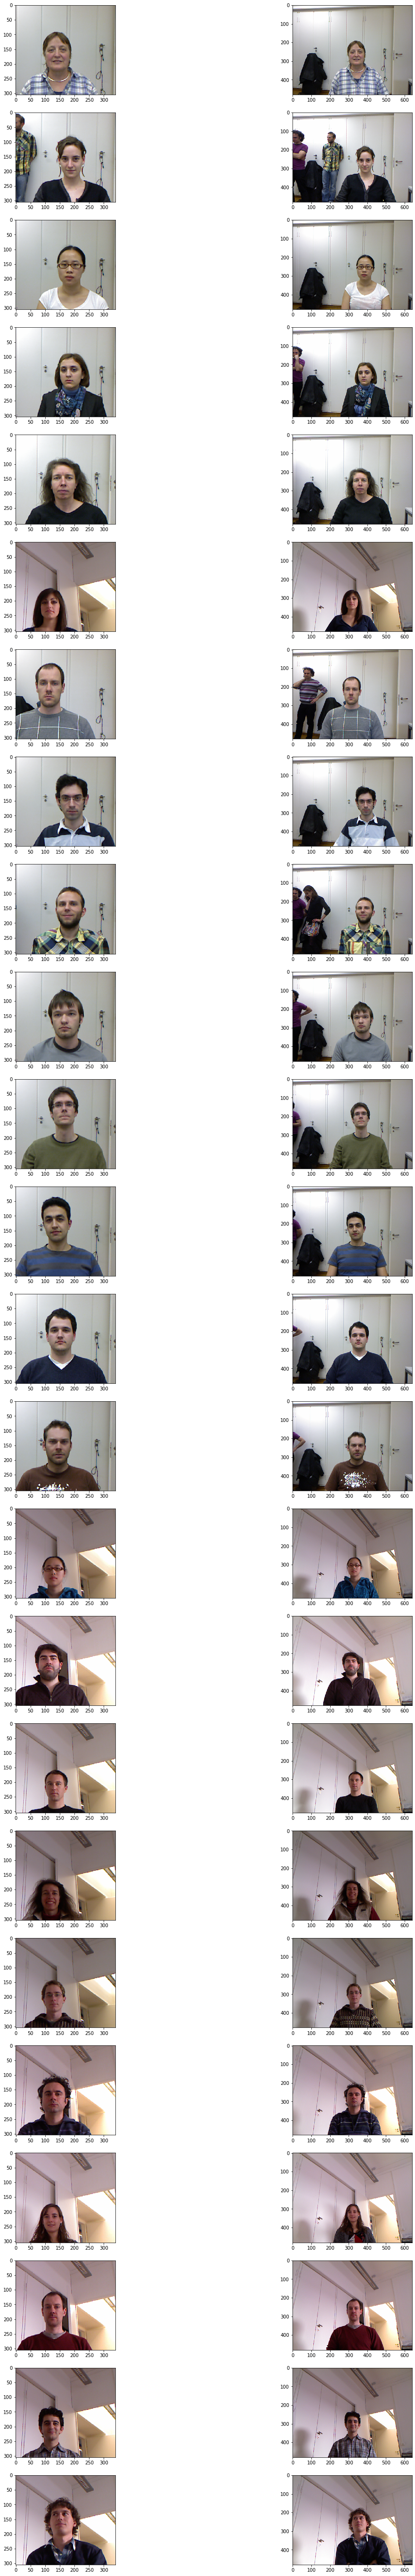

In [12]:
crop()

Making a seperate directory to store the faces

In [0]:
!mkdir cropped_Images

In [0]:
for i in range(1,25):
  path = "cropped_Images/"+"{:02d}".format(i)
  if not os.path.exists(path):
    os.mkdir(path)

In [0]:
# !cp -r 'drive/My Drive/cropped_Images' '/content/'

This function will get the faces and save them in the directory created above

In [0]:
def ExtractAndSaveFaces(ImagesPath):
    jpg_crop_path = []
    count = 0
    for i in tqdm(range(len(ImagesPath))):
        image = cv2.imread(ImagesPath[i])[100:-75,200:540]
        cv2.imwrite("cropped_Images/" + ImagesPath[i][5:] , image) # writing the image to directory
        jpg_crop_path.append("cropped_Images/" + ImagesPath[i][5:])
        count = count+1
    print(str(count) + " image written")
    return jpg_crop_path

In [16]:
CroppedImagesPath = ExtractAndSaveFaces(ImagesPath)


15678 image written


In [0]:
# def ExtractAndSaveFaces(detector,ImagesPath):
#     jpg_crop_path = []
#     count = 0
#     count_fail = 0
#     for i in tqdm(range(len(ImagesPath))):
#         image = cv2.imread(ImagesPath[i])[100:-75,200:540]
#         dets = detector(image, 0)
#         if len(dets) == 1: 
#             crop_img = image[dets[0].rect.top()-50:dets[0].rect.bottom()+50,dets[0].rect.left()-50:dets[0].rect.right()+50] # cropping the image with 50 extra pixels on all side
#             if crop_img.size == 0:
#                 count_fail+=1
#                 continue
#             cv2.imwrite("cropped_Images/" + ImagesPath[i][5:] , crop_img) # writing the image to directory
#             jpg_crop_path.append("cropped_Images/" + ImagesPath[i][5:])
#             count = count+1
#     print(str(count) + " image written")
#     print(str(count_fail) + " image failed")
#     return jpg_crop_path

In [0]:
# CroppedImagesPath = ExtractAndSaveFaces(detector,ImagesPath)

In [17]:
len(CroppedImagesPath)

15678

In [0]:
# !cp -r cropped_Images 'drive/My Drive/'

Getting the path of final images that will be fed to the model

This function will return a dataframe which contains the image id along with its yaw pitch and roll 

In [0]:
def getDataframe(CroppedImagesPath):
    df_train = pd.DataFrame(columns = ['Person','image','pitch','yaw','roll'])
    df_val = pd.DataFrame(columns = ['Person','image','pitch','yaw','roll'])
    df_test = pd.DataFrame(columns = ['Person','image','pitch','yaw','roll'])
    for i in tqdm(range(len(CroppedImagesPath))):
        yaw, pitch, roll = getAngles("hpdb/"+CroppedImagesPath[i][15:30]+"pose.txt")
        if(int(CroppedImagesPath[i][15:17]) < 17):
          df_train = df_train.append({'Person':CroppedImagesPath[i][15:17],'image':CroppedImagesPath[i][18:29],'pitch':pitch,'yaw':yaw,'roll':roll},ignore_index = True)
        elif(int(CroppedImagesPath[i][15:17]) >= 17 and int(CroppedImagesPath[i][15:17]) <= 20):
          df_val = df_val.append({'Person':CroppedImagesPath[i][15:17],'image':CroppedImagesPath[i][18:29],'pitch':pitch,'yaw':yaw,'roll':roll},ignore_index = True)  
        else:
          df_test = df_test.append({'Person':CroppedImagesPath[i][15:17],'image':CroppedImagesPath[i][18:29],'pitch':pitch,'yaw':yaw,'roll':roll},ignore_index = True)  
    return df_train, df_val, df_test

In [20]:
df_train, df_val, df_test = getDataframe(CroppedImagesPath)

# Dataset Class

In [0]:
class BIWIDataset(Dataset):
    def __init__(self, df_train, path, phase):
        self.df = df_train
        self.phase = phase
        # self.transform = transforms.Compose([transforms.ToTensor()])
        self.path = path
        self.train = [path[i] for i in range(len(path)) if int(path[i][15:17]) <= 16]
        self.val = [path[i] for i in range(len(path)) if int(path[i][15:17]) > 16 and int(path[i][15:17]) <= 20]
        self.fnames = self.df.index.tolist()
    
    def __getitem__(self, idx):
      if(self.phase == 'train'):
          Image = cv2.imread(self.train[idx])
          Angle = np.array(self.df.iloc[idx,2:])
      elif(self.phase == 'val'):
          Image = plt.imread(self.val[idx])
          Angle = np.array(self.df.iloc[idx,2:])
      Angle = Angle.astype('float64')*180/math.pi
      Image = cv2.resize(Image,(299,299))
      Image = Image.transpose(2,0,1)  # Making Channel First 
      Image = torch.from_numpy(Image).type(torch.FloatTensor)
      Angle = torch.from_numpy(Angle).type(torch.FloatTensor)
      return Image, Angle
    
    def __len__(self):
        return len(self.fnames)

In [0]:
train = [CroppedImagesPath[i] for i in range(len(CroppedImagesPath)) if int(CroppedImagesPath[i][15:17]) <= 16]
val = [CroppedImagesPath[i] for i in range(len(CroppedImagesPath)) if int(CroppedImagesPath[i][15:17]) > 16 and int(CroppedImagesPath[i][15:17]) <= 20]

In [0]:
def provider(path, phase, batch_size=8, num_workers=0,df_train = df_train, df_val = df_val):
    df = df_train if phase == "train" else df_val
    image_dataset = BIWIDataset(df, path, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

# Trainer Class

In [0]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model, path, epochs, bs, lr):
        self.num_workers = 0
        self.batch_size = bs#{"train": 4, "val": 4}
        self.accumulation_steps = 1 #4 // self.batch_size['train']
        self.lr = lr
        self.num_epochs = epochs
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.L1Loss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                path = path,
                phase=phase,
                batch_size=self.batch_size,
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        targets = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, targets)
        return loss, outputs

    def iterate(self, epoch, phase):
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
            outputs = outputs.detach().cpu()
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        torch.cuda.empty_cache()
        print(f'loss:{epoch_loss}')
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            train_loss = self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            # print()

#Getting the model and Training

In [35]:
!pip install efficientnet_pytorch -q

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=b0fefd8a07150ae72e3e6716bba3df4ffaaab038dd3d54b52f1d0b1eb6de78ca
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch


In [0]:
from efficientnet_pytorch import EfficientNet

In [59]:
model = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [0]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 3)

In [61]:
model_trainer = Trainer(model, CroppedImagesPath,5,32,1e-4)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 07:05:51


RuntimeError: ignored

In [0]:
torch.cuda.empty_cache()